# Функции и класс сплайна

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
class SmoothingSpline:
    def __init__(self, smooth_param = 0.5):
        self.Points = []
        self.alpha = None
        self.SMOOTH = smooth_param
    
    def _transition_to_master_element(self, seg_num, x):
        h = self.Points[seg_num + 1] - self.Points[seg_num]
        return 2.0 * (x - self.Points[seg_num]) / h - 1.0
    
    def _basis_function(self, number, ksi):
        if number == 1: return 0.5 * (1 - ksi)
        elif number == 2: return 0.5 * (1 + ksi)
        else: raise ValueError("Error in basis function number")
    
    def _der_basis_function(self, number, ksi):
        if number == 1: return -0.5
        elif number == 2: return 0.5
        else: raise ValueError("Error in basis function derivative number")
    
    def initialize(self, x_nodes, y_nodes, p = 0.5):
        self.SMOOTH = p
        self.Points = list(x_nodes) if hasattr(x_nodes, '__iter__') else [x_nodes]
        
        num_segments = len(self.Points) - 1
        self.alpha = np.zeros(num_segments + 1)
        
        a = np.zeros(num_segments + 1)
        b = np.zeros(num_segments + 1)
        c = np.zeros(num_segments + 1)
        
        def assembling(i, x_val, f_val, weight):
            ksi = self._transition_to_master_element(i, x_val)
            
            f1 = self._basis_function(1, ksi)
            f2 = self._basis_function(2, ksi)
            
            b[i] += (1.0 - self.SMOOTH) * weight * f1 * f1
            b[i + 1] += (1.0 - self.SMOOTH) * weight * f2 * f2
            a[i + 1] += (1.0 - self.SMOOTH) * weight * f1 * f2
            c[i] += (1.0 - self.SMOOTH) * weight * f2 * f1
            
            self.alpha[i] += (1.0 - self.SMOOTH) * weight * f1 * f_val
            self.alpha[i + 1] += (1.0 - self.SMOOTH) * weight * f2 * f_val
        
        for i in range(num_segments):
            assembling(i, self.Points[i], y_nodes[i], 1.0)
            assembling(i, self.Points[i + 1], y_nodes[i + 1], 1.0)
            
            h = self.Points[i + 1] - self.Points[i]
            
            reg_scale = 1.0 + 99.0 * p * p
            reg_weight = self.SMOOTH * reg_scale
            
            b[i] += reg_weight / h
            b[i + 1] += reg_weight / h
            a[i + 1] -= reg_weight / h
            c[i] -= reg_weight / h
        
        if p > 0.8:
            extra_scale = (p - 0.8) / 0.2
            extra_reg = extra_scale * extra_scale * 500.0
            
            for i in range(num_segments):
                h = self.Points[i + 1] - self.Points[i]
                b[i] += extra_reg / h
                b[i + 1] += extra_reg / h
                
        for j in range(1, num_segments + 1):
            if abs(b[j - 1]) < 1e-12:
                avg = np.mean(y_nodes)
                self.alpha.fill(avg)
                return
            
            m = a[j] / b[j - 1]
            b[j] -= m * c[j - 1]
            self.alpha[j] -= m * self.alpha[j - 1]
        
        if abs(b[num_segments]) < 1e-12:
            avg = np.mean(y_nodes)
            self.alpha.fill(avg)
            return
        
        self.alpha[num_segments] /= b[num_segments]
        for j in range(num_segments - 1, -1, -1):
            self.alpha[j] = (self.alpha[j] - c[j] * self.alpha[j + 1]) / b[j]
    
    def evaluate(self, x):
        if len(self.Points) == 0:
            return 0.0
        
        eps = 1e-7
        num_segments = len(self.Points) - 1
        
        for i in range(num_segments):
            if (self.Points[i] <= x <= self.Points[i + 1] or
                abs(x - self.Points[i]) < eps or
                abs(x - self.Points[i + 1]) < eps):
                
                ksi = self._transition_to_master_element(i, x)
                return (self.alpha[i] * self._basis_function(1, ksi) + 
                        self.alpha[i + 1] * self._basis_function(2, ksi))
        
        if x < self.Points[0]:
            return self.alpha[0]
        if x > self.Points[num_segments]:
            return self.alpha[num_segments]
        
        return 0.0

In [3]:
def splines_visualisation(df):
    data = df.iloc[::20]
    
    plt.figure(figsize=(14, 8))
    plt.plot(data['x'], data['Original'], 'ko', label='Исходные данные', markersize=8)
    for col in data.columns[2:]:
        plt.plot(data['x'], data[col], label=col)
        
    plt.legend(loc=(1.05, 0.5))
    plt.grid(True)
    plt.xlabel('Номер наблюдения')
    plt.ylabel('Значение')
    plt.title('Сглаживающие сплайны')
    plt.show()

In [4]:
n_observations = 1304
mean = 0.94
stdev = 4.28

random_data = pd.read_csv('smoothing_splines.csv')['Original'].tolist()
indices = np.arange(n_observations)

# Тест сплайна через ручную реализацию

In [5]:
splines = []
p_values = [0.0, 0.2, 0.5, 0.8, 0.99]

for p in p_values:
    spline = SmoothingSpline(smooth_param=p)
    spline.initialize(indices, random_data, p)
    splines.append(spline)

data = {'x': indices, 'Original': random_data}

for i, p in enumerate(p_values):
    data[f'p={p}'] = [splines[i].evaluate(float(x)) for x in indices]
    
data = pd.DataFrame(data)

In [6]:
data

,x,Original,p=0.0,p=0.2,p=0.5,p=0.8,p=0.99
0,0,3.146050,3.146050,1.973316,1.035431,0.469121,0.000056
1,1,-1.415000,-1.415000,1.027562,0.953465,0.458723,-0.000009
2,2,6.796970,6.796970,4.021425,1.055457,0.462881,0.000129
3,3,2.968120,2.968120,2.538601,0.711507,0.417831,0.000066
4,4,0.408650,0.408650,0.363004,0.192286,0.352969,0.000008
...,...,...,...,...,...,...,...
1299,1299,1.605230,1.605230,2.637354,1.269221,0.968530,0.000048
1300,1300,-0.805483,-0.805483,0.031841,0.601173,0.878944,-0.000012
1301,1301,-0.304650,-0.304650,-1.223150,0.042380,0.802443,-0.000017
1302,1302,-5.641990,-5.641990,-3.959593,-0.489459,0.734543,-0.000113


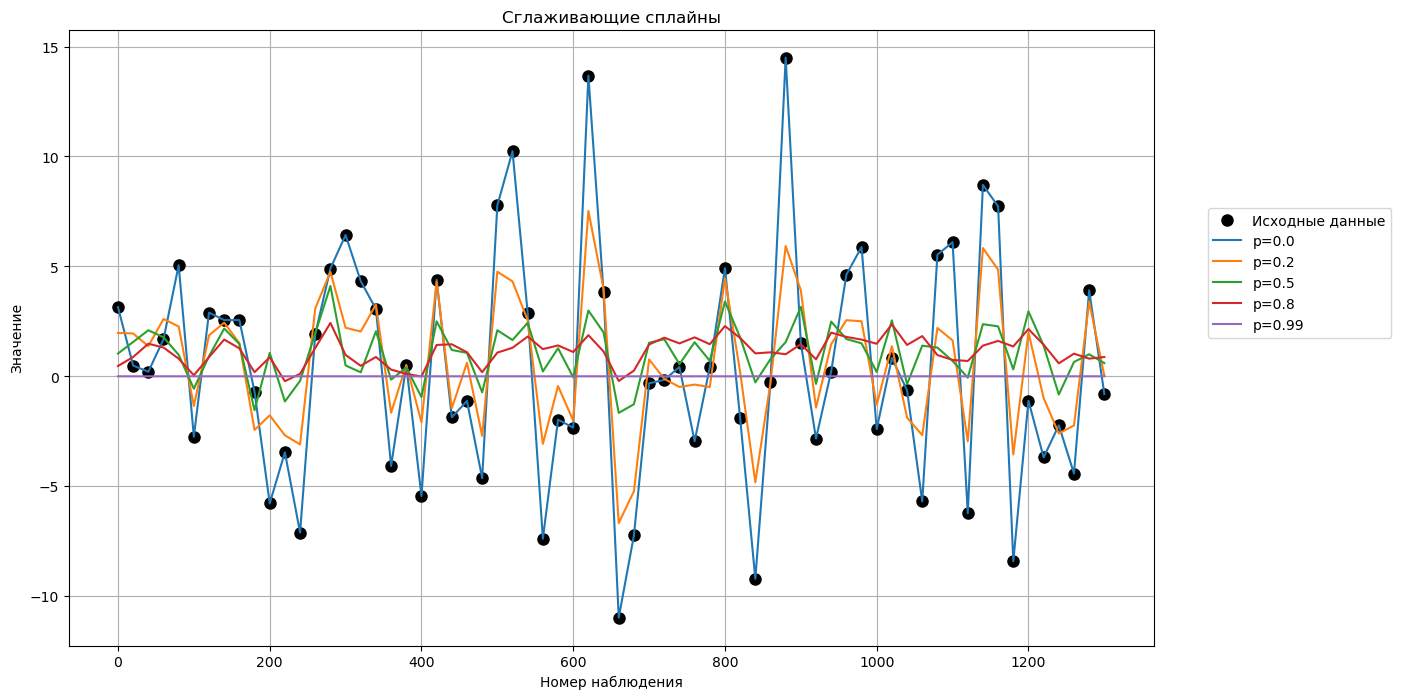

In [7]:
splines_visualisation(data)

# Сплайн через scipy.make_smoothing_spline

In [8]:
from scipy.interpolate import make_smoothing_spline

scipy_splines = []
p_values = [0.0, 0.5, 0.99, 1e5, 1e10]

for p in p_values:
    # Для make_smoothing_spline используем непосредственно p как параметр сглаживания
    # Чем больше p, тем более гладкий сплайн
    spline = make_smoothing_spline(indices, random_data, lam=p)
    scipy_splines.append(spline)

data_scipy = {'x': indices, 'Original': random_data}

for i, p in enumerate(p_values):
    data_scipy[f'p={p}'] = scipy_splines[i](indices)

data_scipy = pd.DataFrame(data_scipy)

In [9]:
data_scipy

,x,Original,p=0.0,p=0.5,p=0.99,p=100000.0,p=10000000000.0
0,0,3.146050,3.146050,2.038792,2.168716,0.323296,0.745452
1,1,-1.415000,-1.415000,2.293365,2.521353,0.346792,0.746103
2,2,6.796970,6.796970,3.526332,3.198510,0.370314,0.746755
3,3,2.968120,2.968120,2.861815,2.479767,0.393885,0.747407
4,4,0.408650,0.408650,0.584100,0.487436,0.417574,0.748059
...,...,...,...,...,...,...,...
1299,1299,1.605230,1.605230,3.715405,3.567783,0.664006,1.425242
1300,1300,-0.805483,-0.805483,0.519179,0.800248,0.652176,1.425413
1301,1301,-0.304650,-0.304650,-1.889698,-1.641071,0.640070,1.425584
1302,1302,-5.641990,-5.641990,-3.909084,-3.708728,0.627807,1.425755


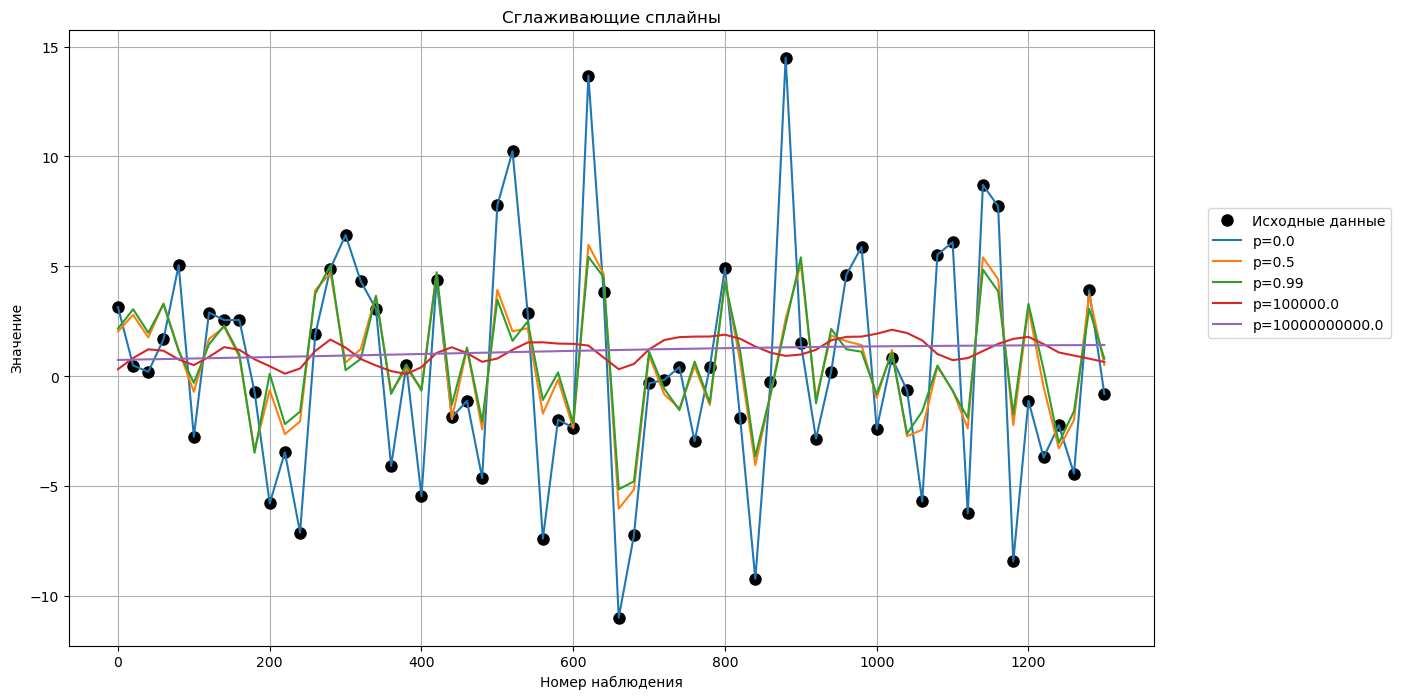

In [10]:
splines_visualisation(data_scipy)

# Сплайн через scipy.UnivariateSpline

In [11]:
from scipy.interpolate import UnivariateSpline

scipy_splines = []
p_values = [0.0, 0.5, 0.99, 1e5, 1e10]

for p in p_values:
    spline = UnivariateSpline(x=indices, y=random_data, s=p)
    scipy_splines.append(spline)

data_scipy = {'x': indices, 'Original': random_data}

for i, p in enumerate(p_values):
    data_scipy[f'p={p}'] = scipy_splines[i](indices)

data_scipy = pd.DataFrame(data_scipy)

In [12]:
data_scipy

,x,Original,p=0.0,p=0.5,p=0.99,p=100000.0,p=10000000000.0
0,0,3.146050,3.146050,3.145825,3.145874,1.032924,1.032924
1,1,-1.415000,-1.415000,-1.413868,-1.414113,1.030287,1.030287
2,2,6.796970,6.796970,6.794469,6.795010,1.027665,1.027665
3,3,2.968120,2.968120,2.971583,2.970833,1.025057,1.025057
4,4,0.408650,0.408650,0.404718,0.405569,1.022463,1.022463
...,...,...,...,...,...,...,...
1299,1299,1.605230,1.605230,1.609777,1.608793,0.882637,0.882637
1300,1300,-0.805483,-0.805483,-0.807541,-0.807096,0.878183,0.878183
1301,1301,-0.304650,-0.304650,-0.304321,-0.304392,0.873712,0.873712
1302,1302,-5.641990,-5.641990,-5.641856,-5.641885,0.869223,0.869223


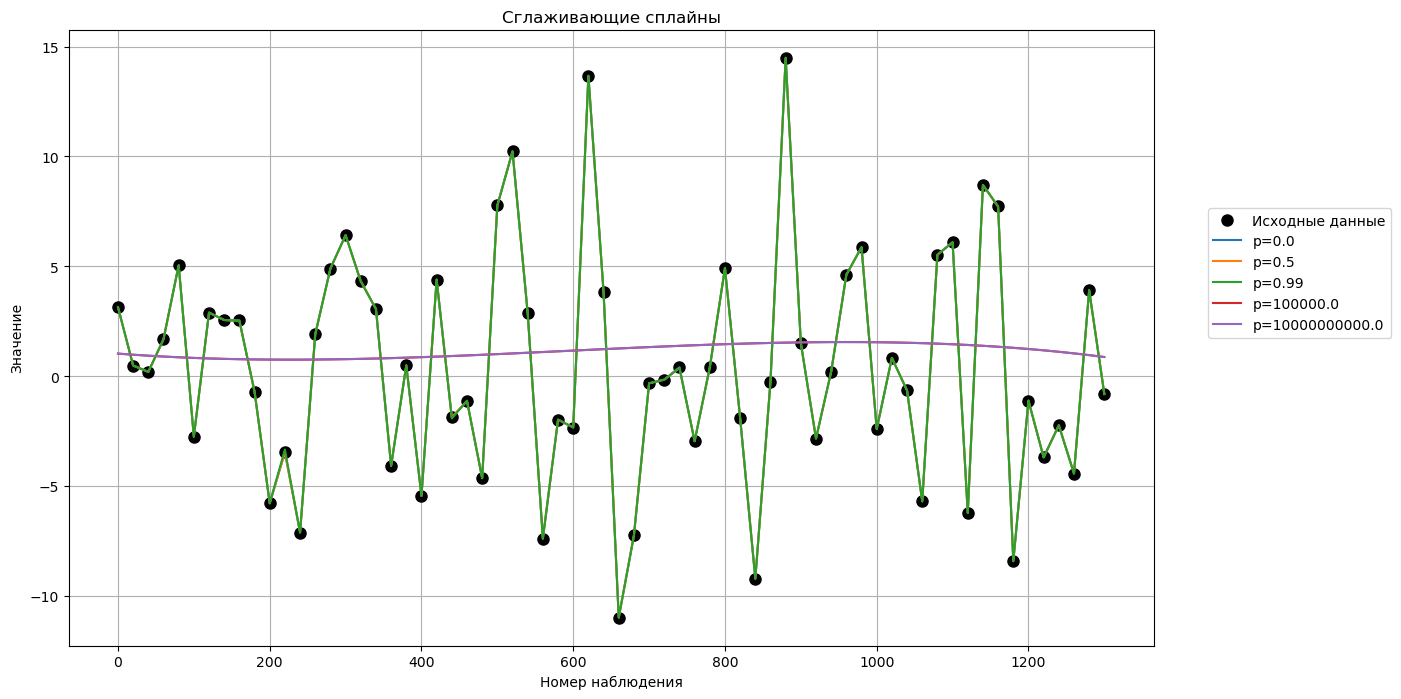

In [13]:
splines_visualisation(data_scipy)